## Data Preparation

In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy
from sklearn.metrics import r2_score
from data import MassMapsDatasetFilteredS8 as MassMapsDataset
from data import ToTensor
import torchvision.transforms.functional as F
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# First step, download data, it takes a few minutes....
! gsutil -m cp -r gs://massivenu/cosmological_parameters.txt .
! gsutil -m cp -r gs://massivenu/z1_256b .

In [ ]:
# Second step, extract data, that also takes a few minutes
! cd z1_256b ; for m in model*.tar.gz; do tar -xzf $m ; rm $m ; done; 

In [ ]:
!cat cosmological_parameters.txt

In [ ]:
data_transform = transforms.Compose([
    ToTensor()
])

In [ ]:
mnu_dataset = MassMapsDataset('cosmological_parameters.txt',  'z1_256b', transform=data_transform)

In [ ]:
figure(figsize=(15,15))
mes = []
s8 = []
om = []
for i in range(len(mnu_dataset)):
    sample = mnu_dataset[i]
    #print(i, sample['image'].shape, sample['params'].shape)

    subplot(5, 5, i + 1)
    tight_layout()
    axis('off')
    imshow(squeeze(sample['image']), cmap='magma',vmin=-0.1,vmax=0.15)
    title(r"$M_\nu=%0.2f ; \Omega_m$=%0.2f; $\sigma_8=%0.2f$"%(sample['params'][0],sample['params'][1],sample['params'][2] ) )
    s8.append(sample['params'][2].numpy())
    om.append(sample['params'][1].numpy())
    mes.append(np.std(sample['image'].numpy()))
    if i == 24:
        break

In [ ]:
sample['image'].shape

torch.Size([1, 256, 256])

## Train a model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model_ft = models.resnet18(pretrained=False)

In [ ]:
# Modifying the model to predict the three cosmological parameters from single channel images
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

In [ ]:
data_transform = transforms.Compose([
        ToTensor()
    ])

In [ ]:
mnu_dataset = MassMapsDataset('cosmological_parameters.txt',
                              'z1_256b', 
                              transform=data_transform)

dataloader = torch.utils.data.DataLoader(mnu_dataset, batch_size=128, 
                                         shuffle=True, num_workers=4)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    losses = []
    learning_rates= []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloader:
                inputs, params = data['image'], data['params']
                inputs = inputs.to(device)
                params = params.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, params)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                losses.append(loss.item())
            if phase == 'train':
                scheduler.step()
                learning_rates.append(scheduler.get_lr())

            epoch_loss = running_loss / len(mnu_dataset)
            
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # # deep copy the model
            # if phase == 'val' and epoch_loss < best_loss:
            #     best_loss = epoch_loss
            #     best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, losses, learning_rates

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = torch.nn.L1Loss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft, loss_trace, lr_trace = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft, loss_trace2, lr_trace2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
plot(loss_trace2[100:])

In [ ]:
plot(lr_trace2)
yscale('log')

In [ ]:
with torch.no_grad():
    for data in dataloader:
        inputs, params = data['image'], data['params']
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model_ft(inputs)
        break

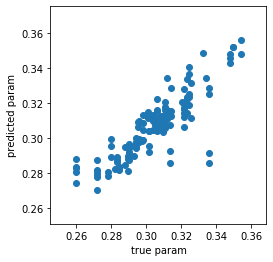

In [ ]:
scatter(params.cpu()[:,1], outputs.cpu()[:,1])
xlabel('true param')
ylabel('predicted param')
#ylim(0.265,0.35)
#xlim(0.265,0.35)
gca().set_aspect('equal')

In [ ]:
coefficient_of_dermination = r2_score(params.cpu()[:,1], outputs.cpu()[:,1])

In [ ]:
coefficient_of_dermination

0.7257992068325176

In [ ]:
# Saving fairly well trained model
torch.save(model_ft.state_dict(), 'resnet18_state_dict')

In [ ]:
torch.save(model_ft, 'resnet18')

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil cp resnet18* gs://massivenu/models_feb20/

Copying file://resnet18 [Content-Type=application/octet-stream]...
Copying file://resnet18_state_dict [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/85.4 MiB.                                     
